In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators

from src.hops import hops_rk_simple
from src.hops import hops_trotter_simple

In [6]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [7]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [1, 2, 4, 8, 1000]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta)
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)

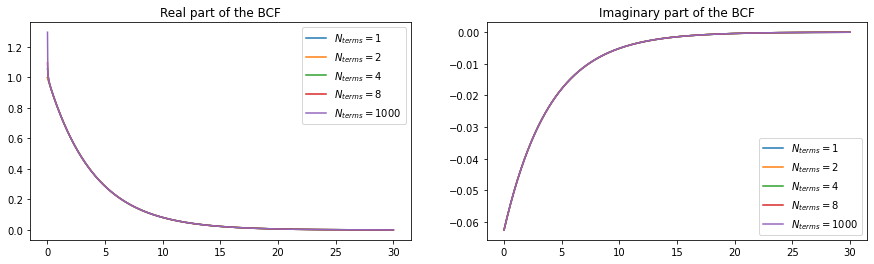

In [8]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].legend()
axarray[0].set_title("Real part of the BCF")
axarray[1].legend()
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

The BCF is sufficiently converged already at $N_\text{terms} = 1$! 

# HOMPS

In [9]:
N_terms = 1

In [10]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [11]:
N_steps = 1000
N_trunc = 40

In [12]:
chimax = 10
eps = 0
N_krylov = 5

Without noise:


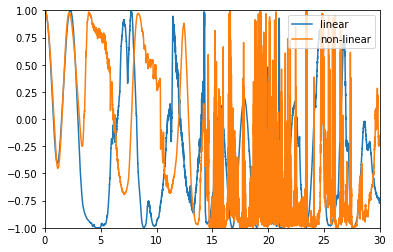

In [351]:
print("Without noise:")
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=eps, N_krylov=N_krylov)
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=eps, N_krylov=N_krylov)
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

without noise


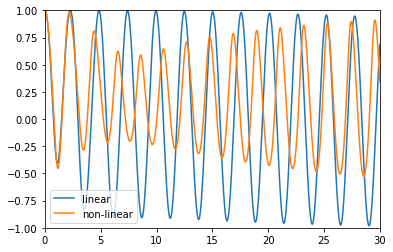

In [348]:
print("without noise")
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False)
psis = hops.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False)
psis = hops.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

# Computing for different N_trunc

In [356]:
N_trunc = 10

In [357]:
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=eps, N_krylov=N_krylov)

In [359]:
psis_100_N_trunc_10 = hierarchy.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
psis_1000_N_trunc_10 = hierarchy.compute_realizations(N_samples=1000, progressBar=tqdm)

In [360]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100_N_trunc_10, sigma_z)

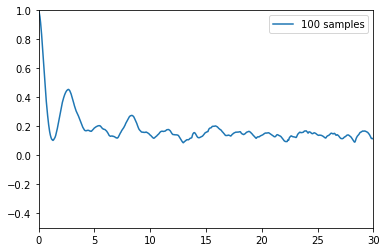

In [361]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

# Using Runge-Kutta HOPS (non-linear)

In [306]:
N_trunc = 40

In [281]:
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True)

In [282]:
psis_100 = hops.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [285]:
psis_1000 = hops.compute_realizations(N_samples=1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [286]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
sigma_zs_1000 = compute_exp_val_nonlinear(psis_1000, sigma_z)

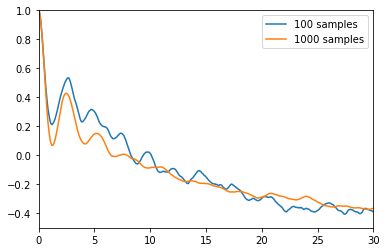

In [287]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

# Fine-tuned comparison (Linear)

In [13]:
N_steps = 1000
N_trunc = 40
chimax = 10
epsilon = 1e-12
duration = 50
N_krylov = 5

In [14]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=True)
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov)

In [15]:
zts = hops.generator.sample_process()

In [16]:
psis_hops = hops.compute_realizations(1, zts_debug=zts)
psis_homps = hierarchy.compute_realizations(1, zts_debug=zts, collect_debug_info=True)

In [17]:
sigma_zs_hops = compute_exp_val_linear(psis_hops, sigma_z)
sigma_zs_homps = compute_exp_val_linear(psis_homps, sigma_z)

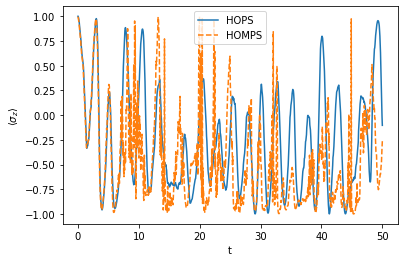

In [18]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps, "--", label="HOMPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.show()

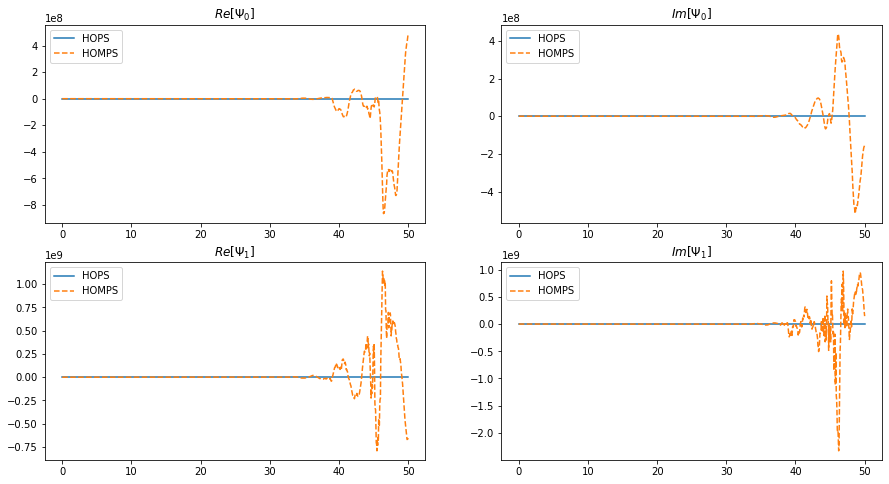

In [19]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 0]), label="HOPS")
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][0].legend()
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 0]), label="HOPS")
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][1].legend()
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 1]), label="HOPS")
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][0].legend()
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 1]), label="HOPS")
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][1].legend()
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

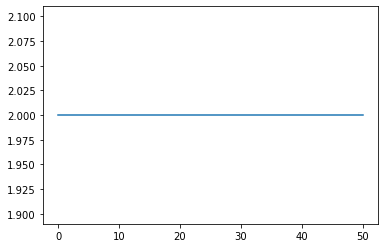

In [20]:
plt.plot(np.linspace(0, duration, N_steps), hierarchy.debug_info["average_bond_dim"][0])
plt.show()

In [21]:
psis_homps1 = hierarchy.compute_realizations(1, zts_debug=zts)
psis_homps2 = hierarchy.compute_realizations(1, zts_debug=zts)

In [22]:
sigma_zs_homps1 = compute_exp_val_linear(psis_homps1, sigma_z)
sigma_zs_homps2 = compute_exp_val_linear(psis_homps2, sigma_z)

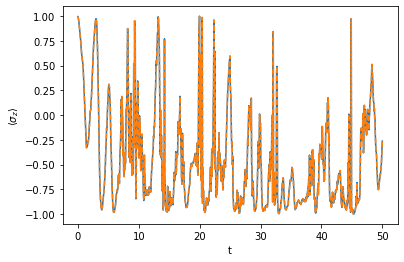

In [24]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps1)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps2, "--")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.show()

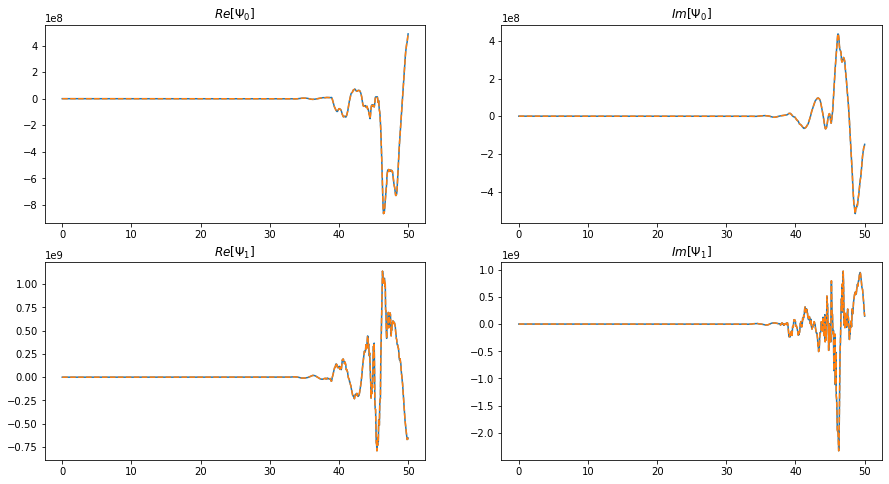

In [28]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps1[0, :, 0]))
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps2[0, :, 0]), "--")
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps1[0, :, 0]))
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps2[0, :, 0]), "--")
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps1[0, :, 1]))
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps2[0, :, 1]), "--")
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps1[0, :, 1]))
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps2[0, :, 1]), "--")
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

# Fine-tuned comparison (Non-Linear)

In [241]:
N_steps = 1000
N_trunc = 20
chimax = 10
epsilon = 1e-12
duration = 50
N_krylov = 5

In [242]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True)
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov)

In [243]:
zts = hops.generator.sample_process()

In [244]:
psis_hops = hops.compute_realizations(1, zts_debug=zts)
psis_homps = hierarchy.compute_realizations(1, zts_debug=zts, collect_debug_info=True)

In [245]:
sigma_zs_hops = compute_exp_val_nonlinear(psis_hops, sigma_z)
sigma_zs_homps = compute_exp_val_nonlinear(psis_homps, sigma_z)

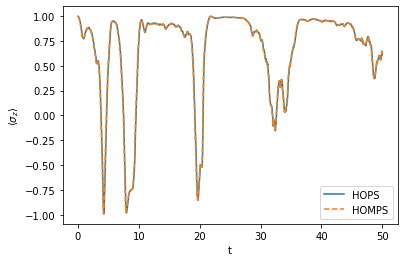

In [246]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps, "--", label="HOMPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.show()

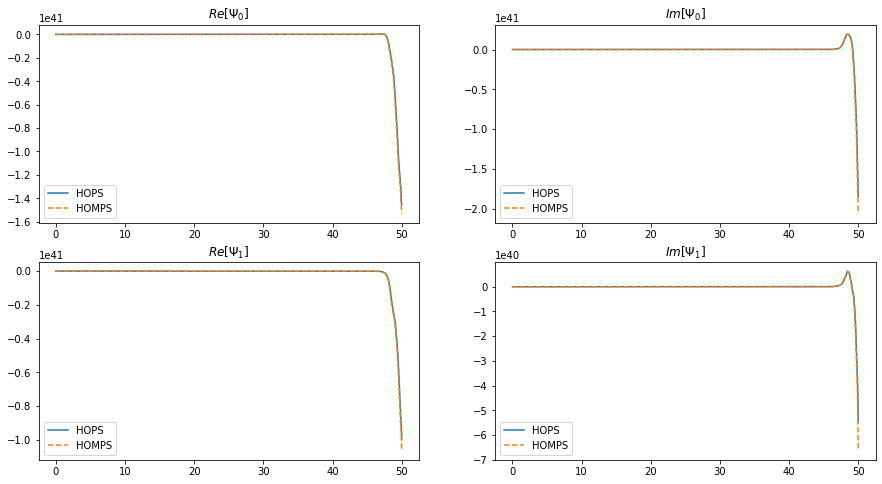

In [247]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 0]), label="HOPS")
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][0].legend()
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 0]), label="HOPS")
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][1].legend()
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 1]), label="HOPS")
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][0].legend()
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 1]), label="HOPS")
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][1].legend()
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

# Comparing MPOs

In [128]:
# comparing MPO
mpo_hops = hops.Heff_linear.toarray()
W0 = hierarchy.model.H_mpo[0] # vL vR i i*
W1 = hierarchy.model.H_mpo[1] # vL vR j j*
left_contr = np.zeros(W0.shape[0])
left_contr[0] = 1.
right_contr = np.zeros(W1.shape[1])
right_contr[-1] = 1.
contr = np.tensordot(left_contr, W0, ([0], [0])) # -> vR i i*
contr = np.tensordot(contr, W1, ([0], [0])) # [vR] i i*; [vL] vR j j* -> i i* vR j j*
contr = np.tensordot(contr, right_contr, ([2], [0])) # -> i i* j j*
contr = np.transpose(contr, (2, 0, 3, 1)) # -> i j i* j*
contr = np.reshape(contr, (contr.shape[0]*contr.shape[1], contr.shape[2]*contr.shape[3]))
mpo_homps = contr

In [129]:
print(np.all((mpo_hops - mpo_homps) == 0))
print(np.sum(np.abs(mpo_hops - mpo_homps)))

True
0.0


The MPOs are identical ...